# Computer vision application with torchvision

In [39]:
DEVICE, FORCE_CPU = "cpu", False
if not FORCE_CPU and torch.backends.mps.is_available():
    DEVICE="mps"
elif not FORCE_CPU and torch.cuda.is_available():
    DEVICE="cuda"
DEVICE

'mps'

## Import dependencies

In [10]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
# from torchvision import transforms
# from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

### Import dataset from torchvision
We are using FashionMNIST

In [11]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

### Data inspection
Find out more about the dataset that we are using

You can inspect the attributes of the class by just typing `train_data.` and see what comes up

In [12]:
len(train_data), len(test_data)

(60000, 10000)

In [13]:
# See the first training example
print(type(train_data[0])) # Tuple
print(len(train_data[0])) # length 2
image, label = train_data[0]
print(f"image.shape={image.shape}") # (1,28,28)
# Each image is 28x28 and only has 1 color channel because it is grayscale
print(f"label={label}")

<class 'tuple'>
2
image.shape=torch.Size([1, 28, 28])
label=9


In [14]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [15]:
# Returns an enumerated dict of the class list
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

We now know that input is a 28x28 grayscale image that's encoded as a tuple, and output that ranges from 0-9 which represents a class/category that the image falls into

## Visualize the data

Running `plt.imshow(image)` returns an error because mpl expects the image channel to come last. Therefore, **we have to remove that dimension when plotting**

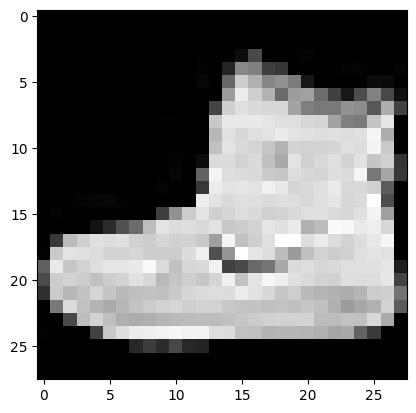

In [16]:
plt.imshow(image.squeeze(), cmap='gray') # .squeeze removes the extra dimension of size 1

### A common pattern when it comes to inspecting data:

#### 1) Generate some kind of random index using 
```python
rand_idx = torch.randint(start, end, size=(1,)).item()
```
`size=[1]` or `size=(1,)` parameter specifies the size of the output tensor as a tuple, and `.item()` returns the only item in a tensor of size 1 (turns tensor into value)

#### 2) Index an instance of training data (X, y) to the random index in the overall dataset
`X, y = training_data[rand_idx]`

#### 3) Display using pyplot
`plt.imshow(X.squeeze(), cmap=gray)` and title being `plt.title(class_names[y])`

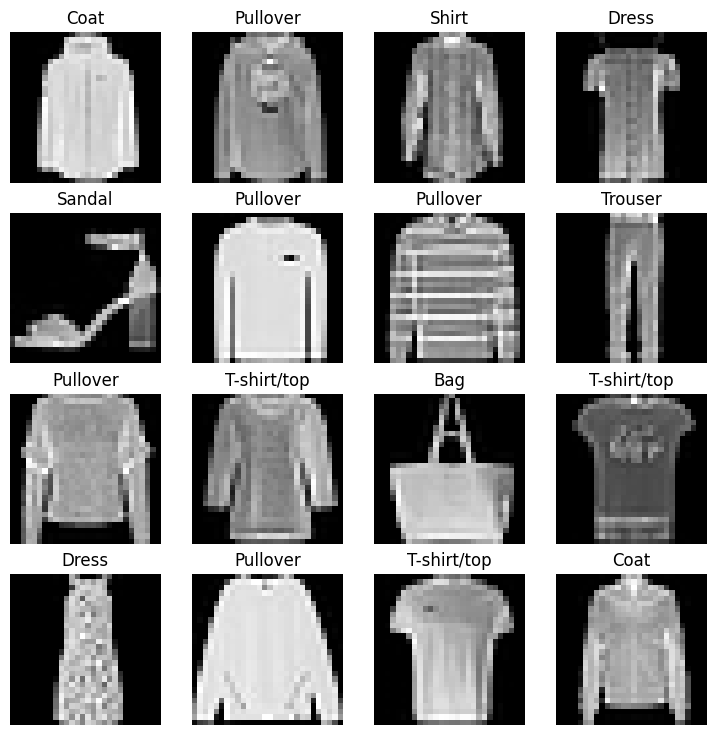

In [17]:
# Plot more images
torch.manual_seed(1001)
fig = plt.figure(figsize=(9,9))
rows, cols= 4, 4
for i in range(1,rows*cols+1):
    rand_idx = torch.randint(0,len(train_data),size=(1,)).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label]) # access the name of class based on train_data.class_to_idx dict provided
    plt.axis(False)

# Preparing a DataLoader
Right now, our data is in the form of a dataset.
DataLoader turns our dataset into a Python iterable.
In particular, we want to turn our data into *batches/minibatches*.

Why?

1. For large datasets, it is not feasible to load the entire dataset into memory at a single go especially when the dataset becomes bigger and images become more detailed. So we brek it down into mini-batches

2. It gives the neural network more changes to update its gradients per epoch (watch mini batch gradient descent by andrew ng)

In [18]:
from torch.utils.data import DataLoader

In [19]:
BATCH_SIZE = 32

In [20]:
train_dl = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
    )
test_dl = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # there's no need to shuffle data here.
    )

In [21]:
# Inspect a training dataloader
train_features_batch, train_labels_batch = next(iter(train_dl))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

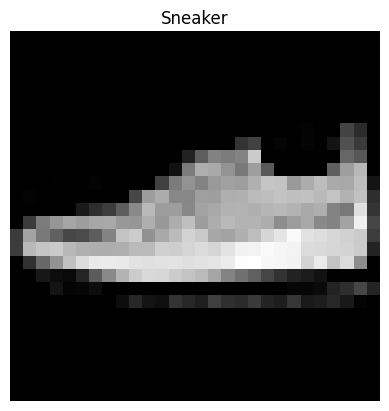

In [22]:
# show a sample
# torch.manual_seed(22)
rand_idx = torch.randint(0,BATCH_SIZE, size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
plt.show()


# Building a baseline model
When starting to build ML models, its important to start with a **baseline**. A baseline model is a simple model that is improved in subsequent iterations.

In [23]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# flatten sample
output = flatten_model(x)

print(f"shape before={x.shape}, shape after={output.shape}")
# now, we can squeeze to remove the extra dimension
output = output.squeeze()

shape before=torch.Size([1, 28, 28]), shape after=torch.Size([1, 784])


The concept is to condense information into a single vector space

## Let's create a linear vectorized model
This consists of only a `nn.Flatten` layer and two linear layers

In [24]:
class FashionModel0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self,x):
        return self.layer_stack(x)

In [25]:
torch.manual_seed(42)
model_0=FashionModel0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(DEVICE)

In [26]:
torch.manual_seed(42)
dummy_x = torch.rand([1,1,28,28]).to(DEVICE)
model_0(dummy_x) # tensor with 10 logits
# If the flatten layer is missing, this doesn't work

tensor([[ 0.1813, -0.3193,  1.3691,  0.9185, -0.1709, -1.0997, -0.3299,  1.6366,
         -0.0506, -0.6301]], grad_fn=<AddmmBackward0>)

# Setting up loss, optimizer and evaluation metrics
Since we are working with multi-class data, we would be working with cross entropy
Let's stick with SGD
and use Accuracy as an evaluation metric

In [27]:
# Let's import a script from helperfunctions.py
import requests
from pathlib import Path

#DL helper functions from learnpytorch repo
if not Path("helper_functions.py").is_file():
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    print("Downloading helper_functions.py")

In [28]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss().to(DEVICE)
optim= torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Timing experiments
You'll want to track a model's:
1) Performance ( Loss and accuracy vals)
2) Speed
since this is a tradeoff

So let's write a helper function to print timedeltas

In [29]:
from timeit import default_timer as timer

def print_train_time(
        start: float,
        end: float,
        device: torch.device = None):
    """Prints delta between start and end"""
    total = end-start
    print(f"Train time on {device}: {total:.3f}s")
    return total

In [30]:
start_time = timer()
# some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device=DEVICE)

Train time on cpu: 0.000s


1.0917021427303553e-05

In [31]:
print(train_dl.__len__())

1875


# Training the baseline model
Creating the training loop on training batches of data (using the data loader)

### Basic Steps
---
1) Loop through epochs
2) Loop through training batches, perform training steps, calculate the train loss **per batch**
3) Loop through testing batches and calculate test loss **per batch**
4) Time it, print, etc for monitoring



In [32]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_cpu = timer()
epochs = 3

# Crate training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss=0
    for batch, (X,y) in enumerate(train_dl):
        # Move onto device
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        # Training mode
        model_0.train()

        # Forward pass
        train_preds = model_0(X)

        # Calculate loss on the BATCHED data (not individual examples)
        loss = loss_fn(train_preds, y)
        
        # Accumulate losses for later
        train_loss+=loss

        optim.zero_grad()

        # Backprop on the BATCHED data
        loss.backward()
        # Gradient step on BATCHED data
        optim.step()

        if batch % 400 == 0:
            print(f"Looked at {len(X)*batch}/{len(train_dl.dataset)} samples")
    
    # Calculate the average training loss per batch
    train_loss /= len(train_dl)

# Testing
test_loss, test_acc = 0,0
model_0.eval()
with torch.inference_mode():
    for X_test, y_test in test_dl:
        X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
        # Forward pass
        test_pred = model_0(X_test)
        test_loss += loss_fn(test_pred, y_test)
        test_acc+= accuracy_fn(y_test, test_pred.argmax(dim=1))
    test_loss /= len(test_dl)
    test_acc /= len(test_dl)

print(f"Train loss:{train_loss:.4f} | Test loss {test_loss:.4f} | Test acc:{test_acc:.4f}")

train_time_end_cpu = timer()
total_trg_time_model_0 = print_train_time(
    start=train_time_start_cpu,
    end=train_time_end_cpu,
    device=str(next(model_0.parameters()).device)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/60000 samples


Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.5024 | Test loss 0.5193 | Test acc:81.9389
Train time on cpu: 6.445s


# Make predictions and get model_0 results

In [33]:
def eval_model(model, dataloader, loss_fn, accuracy_fn):
    """Returns a dict containig the results of a model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(dataloader):
            X,y = X.to(DEVICE), y.to(DEVICE)
            y_preds = model(X)
            
            loss+=loss_fn(y_preds, y) # loss accumulation requires softmaxed values
            acc+=accuracy_fn(y, y_preds.argmax(dim=1))

        # scale loss and acc to find average loss/acc per batch
        loss /= len(dataloader)
        acc /= len(dataloader)

    return {
        "name": model.__class__.__name__,
        "loss": loss.item(),
        "acc": acc
    }

# Calculate model 0 resuts on test dataset
res = eval_model(
    model=model_0,
    dataloader=test_dl,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

res

  0%|          | 0/313 [00:00<?, ?it/s]

{'name': 'FashionModel0', 'loss': 0.5192575454711914, 'acc': 81.93889776357827}

# Building a non-linear model
Let's implement a model with non-linearity

In [34]:
import torch
from torch import nn
class FashionModel1(nn.Module):
    def __init__(self,in_features, hidden_units, out_features):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )
    
    def forward(self, x):
        return self.layer_stack(x)
    
model_1 = FashionModel1(
    in_features=28*28, hidden_units=10,out_features=10
)

## Set up loss and optimizer

In [35]:
loss_fn = nn.CrossEntropyLoss() # same cross
optim_1 = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)

from helper_functions import accuracy_fn

## Functionizing training and testing loops
Let's create a function for training (`train_step()`) and testing (`test_step()`)

In [36]:
def train_step(dl: DataLoader, model: nn.Module, loss_fn: nn.Module, optim: torch.optim.Optimizer):
    train_loss, train_acc = 0, 0
    model.train()
    device = next(model.parameters()).device
    for X,y in dl:
        # You can choose to enumerate through so that you can have a batch variable (as above)
        X, y = X.to(device), y.to(device)
        y_preds = model(X)
        loss = loss_fn(y_preds, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+=loss
        train_acc += accuracy_fn(y, y_preds.argmax(dim=1))
    train_loss/=len(dl)
    train_acc/=len(dl)
    print(f"Training loss={train_loss:.4f}, accuracy={train_acc:.4f}")

In [37]:
def test_step(dl: DataLoader, model: nn.Module, loss_fn: nn.Module):
    test_loss, test_acc = 0,0
    model.eval()
    device = next(model.parameters()).device
    with torch.inference_mode():
        for X,y in dl:
            X, y = X.to(device), y.to(device)
            # Forward pass
            test_preds = model(X)
            test_loss += loss_fn(test_preds, y)
            test_acc += accuracy_fn(y, test_preds.argmax(dim=1))
        test_loss/=len(dl)
        test_acc/=len(dl)
        print(f"Test loss = {test_loss:.5f}, acc = {test_acc:.2f}")

In [41]:
# Create a model and mount it to separate devices
model_1_cpu = model_1.to("cpu")
model_1_gpu = model_1.to(DEVICE)

from timeit import default_timer as timer
from tqdm.auto import tqdm
epochs = 8

start = timer()
for epoch in tqdm(range(epochs)):
    train_step(train_dl,model_1_cpu,loss_fn,optim_1)
    test_step(test_dl,model_1_cpu,loss_fn)
end = timer()
print_train_time(start,end,"cpu")
start = timer()

start=timer()
for epoch in tqdm(range(epochs)):
    train_step(train_dl,model_1_gpu,loss_fn,optim_1)
    test_step(test_dl,model_1_gpu,loss_fn)
end = timer()
print_train_time(start,end,"gpu")






  0%|          | 0/8 [00:00<?, ?it/s]

Training loss=0.4138, accuracy=85.2383
Test loss = 0.44001, acc = 84.53
Training loss=0.4097, accuracy=85.5000
Test loss = 0.44030, acc = 84.64
Training loss=0.4082, accuracy=85.4700
Test loss = 0.45760, acc = 84.05
Training loss=0.4023, accuracy=85.5700
Test loss = 0.45354, acc = 83.98
Training loss=0.3994, accuracy=85.6500
Test loss = 0.55846, acc = 80.05
Training loss=0.3972, accuracy=85.7550
Test loss = 0.46955, acc = 83.74
Training loss=0.3932, accuracy=85.9600
Test loss = 0.47731, acc = 83.68
Training loss=0.3915, accuracy=85.9867
Test loss = 0.44584, acc = 84.16
Train time on cpu: 58.942s


  0%|          | 0/8 [00:00<?, ?it/s]

Training loss=0.3907, accuracy=85.9400
Test loss = 0.47532, acc = 83.02
Training loss=0.3882, accuracy=86.1317
Test loss = 0.46235, acc = 83.70
Training loss=0.3850, accuracy=86.2900
Test loss = 0.46866, acc = 83.50
Training loss=0.3828, accuracy=86.1867
Test loss = 0.43916, acc = 84.86
Training loss=0.3832, accuracy=86.2683
Test loss = 0.50959, acc = 82.28
Training loss=0.3809, accuracy=86.2600
Test loss = 0.45186, acc = 83.89
Training loss=0.3795, accuracy=86.3967
Test loss = 0.44455, acc = 84.45
Training loss=0.3776, accuracy=86.4333
Test loss = 0.47310, acc = 83.97
Train time on gpu: 58.458s


58.45762712499709